In [ ]:
#| echo: false
#| label: 024_imports
import os
from math import inf
import numpy as np
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

This chapter demonstrates hyperparameter tuning for `river`'s `Hoeffding Adaptive Tree Regressor` with the Friedman drift data set [[SOURCE]](https://riverml.xyz/0.18.0/api/datasets/synth/FriedmanDrift/). The `Hoeffding Adaptive Tree Regressor` is a decision tree that uses the Hoeffding bound to limit the number of splits evaluated at each node. The `Hoeffding Adaptive Tree Regressor` is a regression tree, i.e., it predicts a real value for each sample. The `Hoeffding Adaptive Tree Regressor` is a drift aware model, i.e., it can handle concept drifts.



## The Friedman Drift Data Set

We will use the Friedman synthetic dataset with concept drifts [[SOURCE]](https://riverml.xyz/0.18.0/api/datasets/synth/FriedmanDrift/), see also @frie91a and @ikon11a.
Each observation is composed of ten features. Each feature value is sampled uniformly in [0, 1]. Only the first five features are relevant. The target is defined by different functions depending on the type of the drift. Global Recurring Abrupt drift will be used, i.e., the concept drift appears over the whole instance space.

The target is defined by the following function:
$$
y = 10 \sin(\pi x_0 x_1) + 20 (x_2 - 0.5)^2 + 10 x_3 + 5 x_4 + \epsilon,
$$
where $\epsilon \sim \mathcal{N}(0, 1)$ is normally distributed noise.

We will use the Global Recurring Abrupt drift variant of the Friedman Drift dataset.
There are two points of concept drift, namely $p_1$ and $p_2$.
At the second point, the concept changes to:
$$
y = 10 \sin(\pi x_3 x_5) + 20 (x_1 - 0.5)^2 + 10 x_0 + 5 x_2 + \epsilon,
$$
At the second point of drift the old concept reoccurs.
This can be implemented as follows, see [https://riverml.xyz/latest/api/datasets/synth/FriedmanDrift/](https://riverml.xyz/latest/api/datasets/synth/FriedmanDrift/):

```python
def __iter__(self):
    rng = random.Random(self.seed)

    i = 0
    while True:
        x = {i: rng.uniform(a=0, b=1) for i in range(10)}
        y = self._global_recurring_abrupt_gen(x, i) + rng.gauss(mu=0, sigma=1)

        yield x, y
        i += 1
```


```python
def _global_recurring_abrupt_gen(self, x, index: int):
    if index < self._change_point1 or index >= self._change_point2:
        # The initial concept is recurring
        return (
            10 * math.sin(math.pi * x[0] * x[1]) + 20 * (x[2] - 0.5) ** 2 + 10 * x[3] + 5 * x[4]
        )
    else:
        # Drift: the positions of the features are swapped
        return (
            10 * math.sin(math.pi * x[3] * x[5]) + 20 * (x[1] - 0.5) ** 2 + 10 * x[0] + 5 * x[2]
        )
```


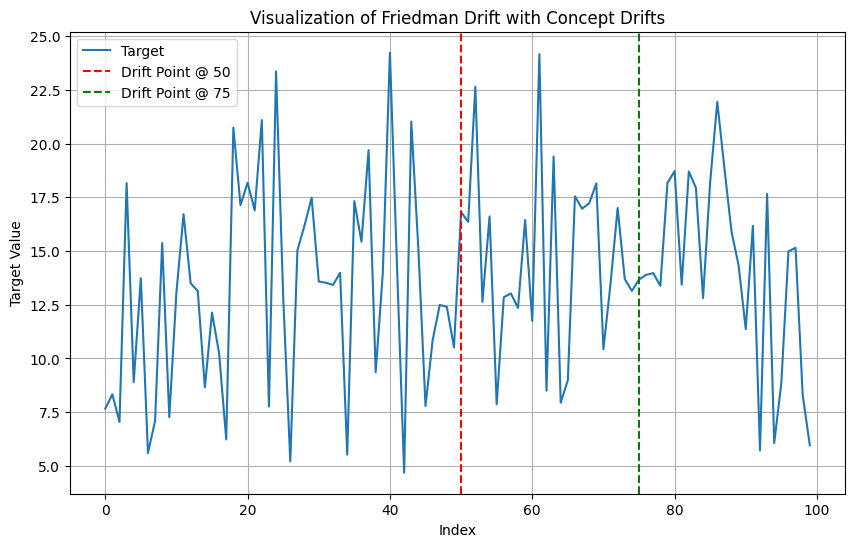

In [1]:
import math
import random
import matplotlib.pyplot as plt

class FriedmanDriftDataset:
    def __init__(self, seed=None, change_point1=50, change_point2=75):
        self.seed = seed
        self._change_point1 = change_point1
        self._change_point2 = change_point2

    def _global_recurring_abrupt_gen(self, x, index: int):
        if index < self._change_point1 or index >= self._change_point2:
            return (10 * math.sin(math.pi * x[0] * x[1]) + 20 * (x[2] - 0.5) ** 2 + 10 * x[3] + 5 * x[4])
        else:
            return (10 * math.sin(math.pi * x[3] * x[5]) + 20 * (x[1] - 0.5) ** 2 + 10 * x[0] + 5 * x[2])

    def __iter__(self):
        rng = random.Random(self.seed)
        i = 0
        while True:
            x = {i: rng.uniform(0, 1) for i in range(10)}
            y = self._global_recurring_abrupt_gen(x, i) + rng.gauss(mu=0, sigma=1)
            yield x, y
            i += 1

# Initialize the dataset generator
dataset = FriedmanDriftDataset(seed=42)
data_generator = iter(dataset)

# Generate 100 data points
points = [next(data_generator)[1] for _ in range(100)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(points, label='Target')
plt.axvline(x=50, color='r', linestyle='--', label='Drift Point @ 50')
plt.axvline(x=75, color='g', linestyle='--', label='Drift Point @ 75')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Visualization of Friedman Drift with Concept Drifts')
plt.legend()
plt.grid(True)
plt.show()

{0: 0.6394267984578837, 1: 0.025010755222666936, 2: 0.27502931836911926, 3: 0.22321073814882275, 4: 0.7364712141640124, 5: 0.6766994874229113, 6: 0.8921795677048454, 7: 0.08693883262941615, 8: 0.4219218196852704, 9: 0.029797219438070344} 7.6612066799391085 0
{0: 0.026535969683863625, 1: 0.1988376506866485, 2: 0.6498844377795232, 3: 0.5449414806032167, 4: 0.2204406220406967, 5: 0.5892656838759087, 6: 0.8094304566778266, 7: 0.006498759678061017, 8: 0.8058192518328079, 9: 0.6981393949882269} 8.330237325619887 1
{0: 0.3402505165179919, 1: 0.15547949981178155, 2: 0.9572130722067812, 3: 0.33659454511262676, 4: 0.09274584338014791, 5: 0.09671637683346401, 6: 0.8474943663474598, 7: 0.6037260313668911, 8: 0.8071282732743802, 9: 0.7297317866938179} 7.044929465589236 2
{0: 0.3785343772083535, 1: 0.552040631273227, 2: 0.8294046642529949, 3: 0.6185197523642461, 4: 0.8617069003107772, 5: 0.577352145256762, 6: 0.7045718362149235, 7: 0.045824383655662215, 8: 0.22789827565154686, 9: 0.28938796360210717

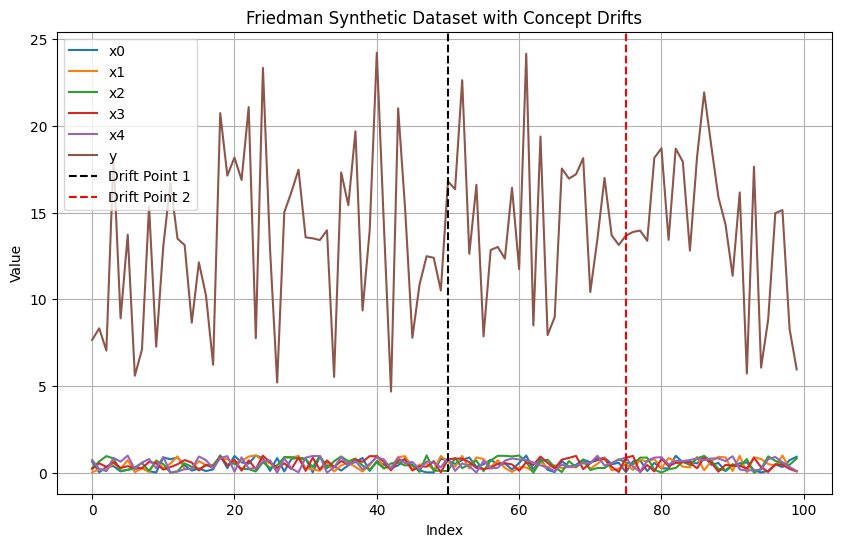

In [6]:
import matplotlib.pyplot as plt
import math
import random

import math
import random

class FriedmanDriftDataset:
    def __init__(self, change_point1=50, change_point2=75, seed=None):
        self._change_point1 = change_point1
        self._change_point2 = change_point2
        self.seed = seed
        self.index = 0
        self.rng = random.Random(self.seed)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= 100:  # Limiting the number of samples for this example
            raise StopIteration
        x = {i: self.rng.uniform(a=0, b=1) for i in range(10)}
        y = self._global_recurring_abrupt_gen(x, self.index) + self.rng.gauss(mu=0, sigma=1)
        result = (x, y, self.index)
        self.index += 1
        return result

    def _global_recurring_abrupt_gen(self, x, index):
        if index < self._change_point1 or index >= self._change_point2:
            return (
                10 * math.sin(math.pi * x[0] * x[1]) +
                20 * (x[2] - 0.5) ** 2 +
                10 * x[3] + 5 * x[4]
            )
        else:
            return (
                10 * math.sin(math.pi * x[3] * x[5]) +
                20 * (x[1] - 0.5) ** 2 +
                10 * x[0] + 5 * x[2]
            )

# Generate data
data_generator = FriedmanDriftDataset(seed=42, change_point1=50, change_point2=75)
data = [data for data in data_generator]  # Now this should work

# Print the first few elements to confirm
for x, y, index in data[:5]:
    print(x, y, index)

# Prepare data
indices = [i for _, _, i in data]
values = {f"x{i}": [] for i in range(5)}
values["y"] = []

for x, y, _ in data:
    for i in range(5):
        values[f"x{i}"].append(x[i])
    values["y"].append(y)

# Plotting
plt.figure(figsize=(10, 6))

for label, series in values.items():
    plt.plot(indices, series, label=label)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Friedman Synthetic Dataset with Concept Drifts')
plt.axvline(x=50, color='k', linestyle='--', label='Drift Point 1')
plt.axvline(x=75, color='r', linestyle='--', label='Drift Point 2')
plt.legend()
plt.grid(True)
plt.show()

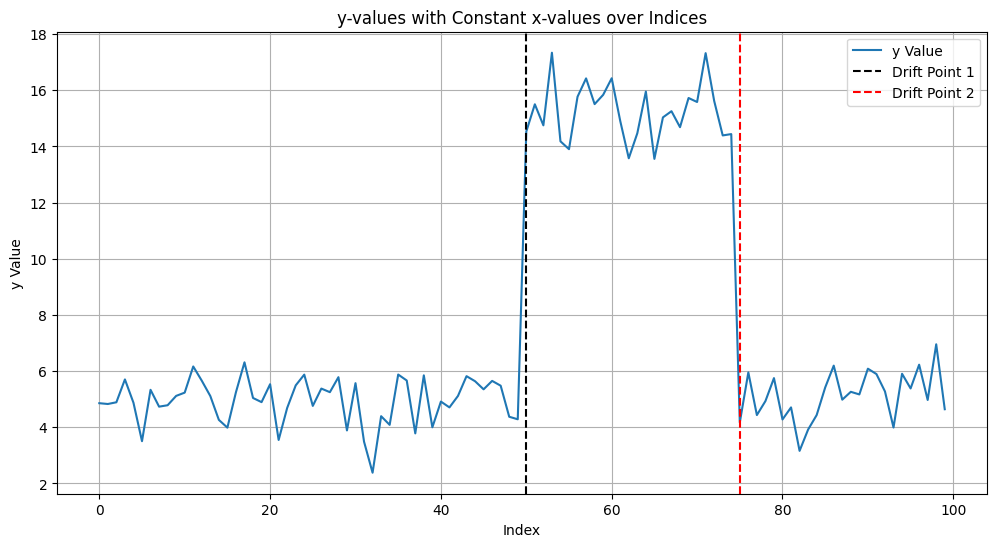

In [9]:
import matplotlib.pyplot as plt
import math
import random

class ConstantXFriedmanDriftDataset:
    def __init__(self, change_point1=50, change_point2=75, seed=None, constant_value=0.5):
        self._change_point1 = change_point1
        self._change_point2 = change_point2
        self.seed = seed
        self.constant_value = constant_value
        self.index = 0
        self.rng = random.Random(self.seed)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= 100:  # Specifying end of generation
            raise StopIteration
        # x[0] is set to 1, all others to 0
        x = {0: 1}
        x.update({i: 0 for i in range(1, 10)})  # All x[i] are 0 for i > 0
        y = self._global_recurring_abrupt_gen(x, self.index) + self.rng.gauss(mu=0, sigma=1)
        result = (x, y, self.index)
        self.index += 1
        return result

    def _global_recurring_abrupt_gen(self, x, index):
        if index < self._change_point1 or index >= self._change_point2:
            return (
                10 * math.sin(math.pi * x[0] * x[1]) +
                20 * (x[2] - 0.5) ** 2 +
                10 * x[3] + 5 * x[4]
            )
        else:
            return (
                10 * math.sin(math.pi * x[3] * x[5]) +
                20 * (x[1] - 0.5) ** 2 +
                10 * x[0] + 5 * x[2]
            )

# Generation of the dataset with constant x-values
data_generator = ConstantXFriedmanDriftDataset(seed=42, change_point1=50, change_point2=75, constant_value=0.5)
data = [next(data_generator) for _ in range(100)]

# Extracting y-values and indices for plotting
y_values = [y for _, y, _ in data]
indices = range(100)

# Plotting the y-values
plt.figure(figsize=(12, 6))
plt.plot(indices, y_values, label="y Value")

plt.xlabel('Index')
plt.ylabel('y Value')
plt.title('y-values with Constant x-values over Indices')
plt.axvline(x=50, color='k', linestyle='--', label='Drift Point 1')
plt.axvline(x=75, color='r', linestyle='--', label='Drift Point 2')
plt.legend()
plt.grid(True)
plt.show()



The following parameters are used to generate and handle the data set:

* horizon: The prediction horizon in hours.
* n_samples: The number of samples in the data set.
* p_1: The position of the first concept drift.
* p_2: The position of the second concept drift.
* position: The position of the concept drifts.
* n_train: The number of samples used for training.

We will use `spotRiver`'s `convert_to_df` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/utils/data_conversion.py) to convert the `river` data set to a `pandas` data frame.
Then we add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column of the dataframe.

In [ ]:
#| label: 024_data_set

from river.datasets import synth
import pandas as pd
import numpy as np
from spotRiver.utils.data_conversion import convert_to_df

seed = 123
shuffle = True
n_train = 6_000
n_test = 4_000
n_samples = n_train + n_test
target_column = "y"

dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_train/4, n_train/2),
   seed=123
)

train = convert_to_df(dataset, n_total=n_train)
train.columns = [f"x{i}" for i in range(1, 11)] + [target_column]


dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_test/4, n_test/2),
   seed=123
)
test = convert_to_df(dataset, n_total=n_test)
test.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

## Setup

Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size, size of the data set, and the experiment name.

* `MAX_TIME`: The maximum run time in seconds for the hyperparameter tuning process.
* `INIT_SIZE`: The initial design size for the hyperparameter tuning process.
* `PREFIX`: The prefix for the experiment name.

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* `MAX_TIME` is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* `INIT_SIZE` is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.
:::

The `oml_grace_period` defines the number of observations that are used for the initial training of the model.

The `weight_coeff` defines a multiplier for the results: results are multiplied by (step/n_steps)**weight_coeff, where n_steps is the total number of iterations.
Results from the beginning have a lower weight than results from the end if weight_coeff > 1. If weight_coeff == 0, all results have equal weight. Note, that the `weight_coeff` is only used internally for the tuner and does not affect the results that are used for the evaluation or comparisons.

The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased.

The `TENSORBOARD_CLEAN` argument is set to `True` to archive the TensorBoard folder if it already exists. This is useful if you want to start a hyperparameter tuning process from scratch.
If you want to continue a hyperparameter tuning process, set `TENSORBOARD_CLEAN` to `False`. Then the TensorBoard folder will not be archived and the old and new TensorBoard files will shown in the TensorBoard dashboard.

## SelectSelect Model (`algorithm`) and `core_model_hyper_dict`

`spotPython` hyperparameter tuning approach uses two components:

1. a model (class) and 
2. an associated hyperparameter dictionary. 

Here, the `river` model class `HoeffdingAdaptiveTreeRegressor` [[SOURCE]](https://riverml.xyz/dev/api/tree/HoeffdingAdaptiveTreeRegressor/) is selected.

The corresponding hyperparameters are loaded from the associated dictionary, which is stored as a JSON file [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json). The JSON file contains hyperparameter type information, names, and bounds. 

The method `add_core_model_to_fun_control` adds the model and the hyperparameter dictionary to the `fun_control` dictionary.

Alternatively, you can load a local hyper_dict. Simply set `river_hyper_dict.json` as the filename. If `filename`is set to `None`, which is the default, the hyper_dict [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json) is loaded from the `spotRiver` package.

We use the `StandardScaler` [[SOURCE]](https://riverml.xyz/dev/api/preprocessing/StandardScaler/) from `river` as the preprocessing model. The `StandardScaler` is used to standardize the data set, i.e., it has zero mean and unit variance.

## Objective Function

### The Objective Function {#sec-the-objective-function-13}

The objective function `fun_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/fun/hyperriver.py) is selected next.

## Selection of the Objective (Loss) Function

The `metric_sklearn` is used for the sklearn based evaluation via `eval_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_bml.py). Here we use the ` mean_absolute_error` [[SOURCE]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as the objective function.

:::{.callout-note}
#### Note: Additional metrics
`spotRiver` also supports additional metrics. For example, the `metric_river` is used for the river based evaluation via `eval_oml_iter_progressive` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_oml.py). The `metric_river` is implemented to simulate the behaviour of the "original" `river` metrics.
:::

`spotRiver` provides information about the model' s score (metric), memory, and time.
The hyperparamter tuner requires a single objective.
Therefore, a weighted sum of the metric, memory, and time is computed. The weights are defined in the `weights` array.

:::{.callout-note}
#### Note: Weights
The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased.
:::

The `oml_grace_period` defines the number of observations that are used for the initial training of the model. The `step` defines the iteration number at which to yield results. This only takes into account the predictions, and not the training steps.  The `weight_coeff` defines a multiplier for the results: results are multiplied by (step/n_steps)**weight_coeff, where n_steps is the total number of iterations. 
Results from the beginning have a lower weight than results from the end if weight_coeff > 1. If weight_coeff == 0, all results have equal weight. Note, that the `weight_coeff` is only used internally for the tuner and does not affect the results that are used for the evaluation or comparisons.

In [ ]:
from spotPython.utils.init import fun_control_init, design_control_init, surrogate_control_init, optimizer_control_init
from spotRiver.fun.hyperriver import HyperRiver
from spotGUI.tuner.spotRun import get_metric_sklearn, get_prep_model, get_core_model_from_name
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
)
from spotRiver.hyperdict.river_hyper_dict import RiverHyperDict

PREFIX = "024"
# core_model_name = "tree.HoeffdingAdaptiveTreeRegressor"
core_model_name = "tree.HoeffdingTreeRegressor"
fun_evals = inf
horizon = 7*24
max_time = 10
init_size = 10
metric_sklearn_name = "mean_absolute_error"
prep_model_name = "StandardScaler"
hyperdict = RiverHyperDict

oml_grace_period = horizon
weight_coeff = 1.0
weights = np.array([1, 0.01, 0.01])

fun = HyperRiver().fun_oml_horizon

fun_control = fun_control_init(
    PREFIX=PREFIX,
    TENSORBOARD_CLEAN=True,
    core_model_name=core_model_name,
    fun_evals=fun_evals,
    horizon=horizon,
    max_time=max_time,
    metric_sklearn=get_metric_sklearn(metric_sklearn_name),
    metric_sklearn_name=metric_sklearn_name,
    noise=True,
    oml_grace_period=oml_grace_period,
    prep_model_name=prep_model_name,
    prep_model=get_prep_model(prep_model_name),
    seed=seed,
    target_column=target_column,
    test=test,
    train=train,
    weight_coeff=weight_coeff,
    weights=weights,)

coremodel, core_model_instance = get_core_model_from_name(core_model_name)
add_core_model_to_fun_control(
    core_model=core_model_instance,
    fun_control=fun_control,
    hyper_dict=hyperdict,
    filename=None,
)

design_control = design_control_init(
    init_size=init_size,
)

surrogate_control = surrogate_control_init(
    noise=True,
    n_theta=2,
    min_Lambda=1e-3,
    max_Lambda=10,
)

optimizer_control = optimizer_control_init()

In [ ]:
# from spotPython.hyperparameters.values import modify_hyper_parameter_levels
# levels = ["LinearRegression"]
# modify_hyper_parameter_levels(fun_control, "leaf_model", levels)

In [ ]:
from spotPython.utils.eda import gen_design_table
from spotPython.spot import spot
print(gen_design_table(fun_control))

### Run the `Spot` Optimizer

The class `Spot` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py) is the hyperparameter tuning workhorse. It is initialized with the following parameters:

* `fun`: the objective function
* `fun_control`: the dictionary with the control parameters for the objective function
* `design`: the experimental design
* `design_control`: the dictionary with the control parameters for the experimental design
* `surrogate`: the surrogate model
* `surrogate_control`: the dictionary with the control parameters for the surrogate model
* `optimizer`: the optimizer
* `optimizer_control`: the dictionary with the control parameters for the optimizer

:::{.callout-note}
#### Note: Total run time
 The total run time may exceed the specified `max_time`, because the initial design (here: `init_size` = INIT_SIZE as specified above) is always evaluated, even if this takes longer than `max_time`.
:::

In [ ]:
spot_tuner = spot.Spot(
    fun=fun,
    fun_control=fun_control,
    design_control=design_control,
    surrogate_control=surrogate_control,
    optimizer_control=optimizer_control,
)
res = spot_tuner.run()

## Results

### TensorBoard {#sec-tensorboard-10}

Now we can start TensorBoard in the background with the following command, where `./runs` is the default directory for the TensorBoard log files:

```{raw}
tensorboard --logdir="./runs"
```

:::{.callout-tip}
#### Tip: TENSORBOARD_PATH
The TensorBoard path can be printed with the following command:

In [ ]:
#| label: 024_tensorboard_path
from spotPython.utils.init import get_tensorboard_path
get_tensorboard_path(fun_control)

In [ ]:
#| label: 024_print_results
spot_tuner.print_results(print_screen=False)

The tuned hyperparameters can be obtained as a dictionary with the following command:

In [ ]:
from spotPython.hyperparameters.values import get_tuned_hyperparameters
get_tuned_hyperparameters(spot_tuner, fun_control)

The results can be saved and reloaded with the following commands:

In [ ]:
from spotPython.utils.file import save_pickle, load_pickle
from spotPython.utils.init import get_experiment_name
experiment_name = get_experiment_name(PREFIX)
SAVE_AND_LOAD = False
if SAVE_AND_LOAD == True:
    save_pickle(spot_tuner, experiment_name)
    spot_tuner = load_pickle(experiment_name)

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.

In [ ]:
spot_tuner.plot_progress(log_y=True, filename=None)

Results can also be printed in tabular form.

In [ ]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

A histogram can be used to visualize the most important hyperparameters.

In [ ]:
spot_tuner.plot_importance(threshold=0.1)

## Get Default Hyperparameters

The default hyperparameters, which will be used for a comparion with the tuned hyperparameters, can be obtained with the following commands:

In [ ]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
X_start = get_default_hyperparameters_as_array(fun_control)
model_default = get_one_core_model_from_X(X_start, fun_control, default=True)
model_default

:::{.callout-note}
#### Note: `spotPython` tunes numpy arrays
* `spotPython` tunes numpy arrays, i.e., the hyperparameters are stored in a numpy array.
::::

The model with the default hyperparameters can be trained and evaluated with the following commands:

In [ ]:
from spotRiver.evaluation.eval_bml import eval_oml_horizon

df_eval_default, df_true_default = eval_oml_horizon(
                    model=model_default,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

The three performance criteria, i.e., score (metric), runtime, and memory consumption, can be visualized with the following commands:

In [ ]:
#| label: 024_plot_bml_oml_horizon_metrics_default
from spotRiver.evaluation.eval_bml import plot_bml_oml_horizon_metrics, plot_bml_oml_horizon_predictions
df_labels=["default"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

### Show Predictions

* Select a subset of the data set for the visualization of the predictions:
    * We use the mean, $m$, of the data set as the center of the visualization.
    * We use 100 data points, i.e., $m \pm 50$ as the visualization window.

In [ ]:
#| label: 024_plot_bml_oml_horizon_predictions_default
m = fun_control["test"].shape[0]
a = int(m/2)-50
b = int(m/2)+50
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b]], target_column=target_column,  df_labels=df_labels)

## Get SPOT Results

In a similar way, we can obtain the hyperparameters found by `spotPython`.

In [ ]:
#| label: 024_get_one_core_model_from_X
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)

In [ ]:
#| label: 024_eval_om_horizon
df_eval_spot, df_true_spot = eval_oml_horizon(
                    model=model_spot,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

In [ ]:
#| label: 024_plot_bml_oml_horizon_metrics
df_labels=["default", "spot"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default, df_eval_spot], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

In [ ]:
#| label: 024_plot_bml_oml_horizon_predictions
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b], df_true_spot[a:b]], target_column=target_column,  df_labels=df_labels)

In [ ]:
#| label: 024_plot_actual_vs_predicted
from spotPython.plot.validation import plot_actual_vs_predicted
plot_actual_vs_predicted(y_test=df_true_default[target_column], y_pred=df_true_default["Prediction"], title="Default")
plot_actual_vs_predicted(y_test=df_true_spot[target_column], y_pred=df_true_spot["Prediction"], title="SPOT")

## Visualize Regression Trees

In [ ]:
#| label: 024_model_default_learn_one
dataset_f = dataset.take(n_samples)
print(f"n_samples: {n_samples}")
for x, y in dataset_f:
    model_default.learn_one(x, y)

:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::

In [ ]:
# model_default.draw()

In [ ]:
#| label: 024_model_default_summary
model_default.summary

### Spot Model

In [ ]:
#| label: 024_model_spot_learn_one
print(f"n_samples: {n_samples}")
dataset_f = dataset.take(n_samples)
for x, y in dataset_f:
    model_spot.learn_one(x, y)

:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::

In [ ]:
# model_spot.draw()

In [ ]:
#| label: 024_model_spot_summary
model_spot.summary

In [ ]:
#| label: 024_compare_two_tree_models
from spotPython.utils.eda import compare_two_tree_models
print(compare_two_tree_models(model_default, model_spot))

## Detailed Hyperparameter Plots

In [ ]:
#| label: 024_plot_important_hyperparameter_contour
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

## Parallel Coordinates Plots

In [ ]:
#| label: 024_parallel_plot
spot_tuner.parallel_plot()